In [499]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Daten einlesen & vorbereiten:

In [466]:
df = pd.read_csv('../daten/Emmental.csv', sep=';')

In [467]:
# Datetime-Spalten erstellen
df = df[['status', 'timestamps.effective_pickup', 'timestamps.effective_dropoff', 'pickup.station_chosen_confirmation_addr', 'dropoff.station_chosen_confirmation_addr']]
df['timestamps.effective_pickup'] = pd.to_datetime(df['timestamps.effective_pickup'])
df['timestamps.effective_dropoff'] = pd.to_datetime(df['timestamps.effective_dropoff'])

In [468]:
# Nur Fahrten übernehmen, die tatsächlich stattgefunden haben
df = df[df['timestamps.effective_dropoff'].notna() & df['timestamps.effective_pickup'].notna()]
df = df[df['status'] == 'FINISHED']
print('Anzahl Fahrten insgesamt: ', len(df))

Anzahl Fahrten insgesamt:  14855


In [469]:
# Neues DF mit Counts pro Stunde & Station erstellen
df = df[['timestamps.effective_pickup', 'status', 'pickup.station_chosen_confirmation_addr']]
df = df.groupby([pd.Grouper(key='timestamps.effective_pickup', freq='D'), pd.Grouper(key='timestamps.effective_pickup', freq='H'), 'pickup.station_chosen_confirmation_addr']).count()
df.index.names = ['days', 'days_hours', 'station']
df = pd.DataFrame({'Datum': df.index.get_level_values('days_hours'), 'Station': df.index.get_level_values('station'), 'cnt': df.reset_index()['status']})

In [470]:
# Nummern pro Station vergeben
all_stations = df['Station'].unique()
df['station_nr'] = [np.where(all_stations == x)[0][0] for x in df['Station']]
print('Anzahl Stationen: ', len(df['station_nr'].unique()))
print(len(df['Station'].unique()))

Anzahl Stationen:  208
208


In [471]:
df

,Datum,Station,cnt,station_nr
0,2020-08-22 11:00:00,Rüegsau - Mühlegasse 5_alt_2021-01-31,1,0
1,2020-08-22 11:00:00,Rüegsauschachen - Gerbestrasse 3_inaktiv_2021-...,2,1
2,2020-08-23 16:00:00,Hasle-Rüegsau - Bahnhof (BLS),1,2
3,2020-08-23 17:00:00,Affoltern i.E. - Emmentaler Schaukäserei,1,3
4,2020-08-23 17:00:00,Biembach i.E. - Schulhaus_inaktiv_2021-09-01,1,4
...,...,...,...,...
13756,2023-01-10 19:00:00,Burgdorf - Bahnhof (BLS),1,111
13757,2023-01-10 19:00:00,Hasle b.B. - Gewerbepark Dicki,1,81
13758,2023-01-10 20:00:00,Hasle-Rüegsau - Bahnhof (BLS),1,2
13759,2023-01-10 21:00:00,Rüegsauschachen - Schulhaus,1,102


Datenset pro Station erstellen:

In [472]:
date_range = pd.DataFrame(pd.date_range(start=df.Datum.dt.date.min(), end=df.Datum.dt.date.max(), freq='H'), columns=['Datum'])

In [473]:
station_dfs = []

for nr in df.station_nr.unique():
    station_df = df[df.station_nr == nr]
    
    station_df_full = pd.merge(date_range, station_df, on=['Datum'], how='left')
    station_df_full['cnt'] = station_df_full['cnt'].fillna(0)

    station_df_full['Station'] = station_df.iloc[0].Station
    station_df_full['station_nr'] = station_df.iloc[0].station_nr

    # Datums-Spalten hinzufügen
    station_df_full['year'] = station_df_full['Datum'].dt.year
    station_df_full['month'] = station_df_full['Datum'].dt.month
    station_df_full['weekday'] = station_df_full['Datum'].dt.weekday
    station_df_full['hour'] = station_df_full['Datum'].dt.hour

    # Für rt_processing vorbereiten
    station_df_full = station_df_full.set_index('Datum')
    station_df_full = station_df_full.sort_index()

    station_dfs.append(station_df_full)

Stationen mit weniger als 100 Einträgen (Stundenbereiche) bei denen min. 1 Fahrt registriert wurde:

In [479]:
counter = 0
i = 0
stations_o100 = []
for df in station_dfs:
    if len(df[df.cnt > 0]) < 100:
        counter += 1
    else:
        stations_o100.append(i)
    i+=1

print('Anzahl Stationen, die weniger als 100 Stunden mit registrierten Fahrten haben: ', counter)
print('Stationen, die mehr als 100 haben: ', stations_o100)

Anzahl Stationen, die weniger als 100 Stunden mit registrierten Fahrten haben:  185
Stationen, die mehr als 100 haben:  [2, 3, 5, 7, 15, 16, 17, 22, 26, 32, 33, 37, 48, 74, 77, 81, 82, 85, 88, 101, 111, 159, 204]


DF's auf Bereiche, in denen die Stationen aktiv sind kürzen:

<AxesSubplot:>

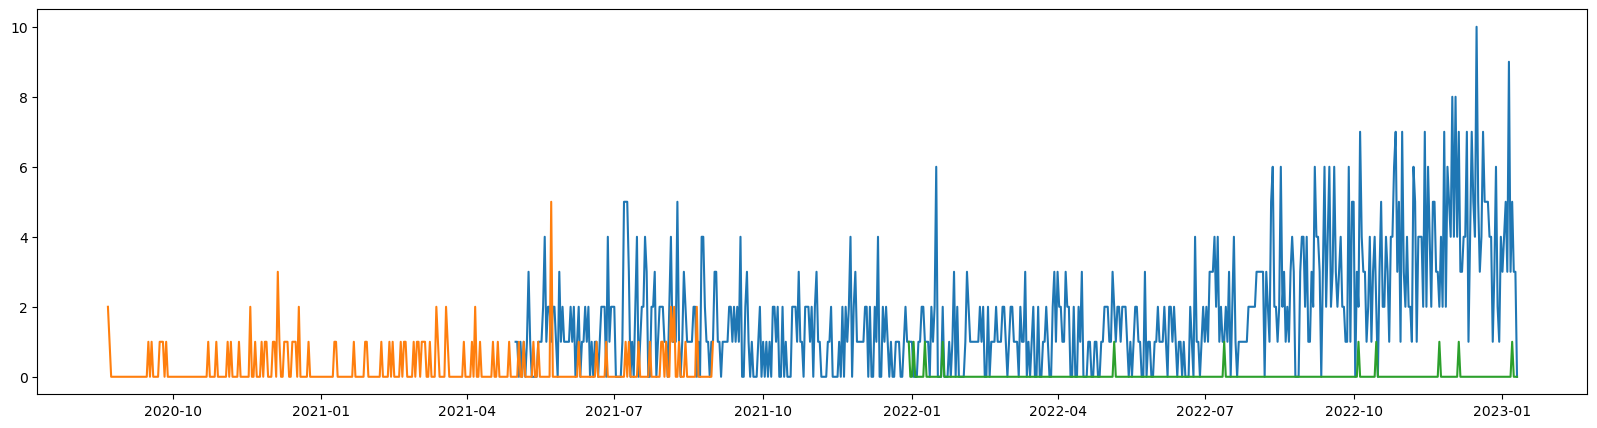

In [397]:
station_dfs[111].groupby(station_dfs[111].index.date).cnt.sum().plot(figsize=(20,5))
station_dfs[1].groupby(station_dfs[1].index.date).cnt.sum().plot(figsize=(20,5))
station_dfs[164].groupby(station_dfs[164].index.date).cnt.sum().plot(figsize=(20,5))

Wie man sieht gibt es Stationen die nicht mehr aktiv sind, später aktiv geworden sind oder über den ganzen Zeitraum aktiv waren.

--> Die inaktiven Bereiche müssen gelöscht werden

In [402]:
# Funktion zum Lücken erkennen (Wenn grösser als 3 Monate):
def find_gaps(df):
    threshold = 2160 # 2160 Stunden in 90 Tagen
    mask = df['cnt'].rolling(window=threshold, min_periods=1).max() <= 0 
    start_times = df[mask & ~mask.shift(1).fillna(False)].index
    start_times = [x - timedelta(hours=threshold-1) if x != datetime(2020, 8, 22, 0, 0, 0) else x for x in start_times]
    end_times = df[mask & ~mask.shift(-1).fillna(False)].index
    ranges = list(zip(start_times, end_times))
    return ranges

In [403]:
i = 0
gap_dfs = []

for df in station_dfs:
    gaps = find_gaps(df)

    for gap in gaps:
                
        # Löschen der Ranges am Anfang
        if datetime(2020, 8, 22, 0, 0, 0) in gap:
            print(i, gap)
            range = pd.date_range(gap[0], gap[1], freq='H')
            station_dfs[i] = df.drop(range)

        # Löschen der Ranges am Ende
        if datetime(2023, 1, 10, 0, 0, 0) in gap:
            print(i, gap)
            range = pd.date_range(gap[0], gap[1], freq='H')
            station_dfs[i] = df.drop(range).sort_index()

    i += 1

In [395]:
#station_dfs[164].loc[station_dfs[164].index.intersection(pd.date_range(datetime(2022, 9, 12, 21, 0, 0), datetime(2022, 10, 4, 19, 0, 0), freq='H'))]

,Station,cnt,station_nr,year,month,weekday,hour
2022-09-12 21:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,9,0,21
2022-09-12 22:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,9,0,22
2022-09-12 23:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,9,0,23
2022-09-13 00:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,9,1,0
2022-09-13 01:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,9,1,1
...,...,...,...,...,...,...,...
2022-10-04 15:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,10,1,15
2022-10-04 16:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,10,1,16
2022-10-04 17:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,10,1,17
2022-10-04 18:00:00,Lützelflüh - Dorfstrasse 18 (Parkplatz),0.0,164,2022,10,1,18


### Beispiel mit Station-Nr 111 (Burgdorf - Bahnhof (BLS)):

In [404]:
station_dfs[111]

,Station,cnt,station_nr,year,month,weekday,hour
Datum,,,,,,,
2021-05-01 00:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2021,5,5,0
2021-05-01 01:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2021,5,5,1
2021-05-01 02:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2021,5,5,2
2021-05-01 03:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2021,5,5,3
2021-05-01 04:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2021,5,5,4
...,...,...,...,...,...,...,...
2023-01-09 20:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2023,1,0,20
2023-01-09 21:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2023,1,0,21
2023-01-09 22:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2023,1,0,22


In [487]:
print('Anzahl Einträge mit min. 1 Fahrt: ', len(station_dfs[111][station_dfs[111].cnt > 0]))

Anzahl Einträge mit min. 1 Fahrt:  1012


In [488]:
station_dfs[111]['cnt'].describe()

count    20905.000000
mean         0.053384
std          0.249418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: cnt, dtype: float64

In [489]:
station_dfs[111].corr()

,cnt,station_nr,year,month,weekday,hour
cnt,1.000000,NaN,0.138784,0.062749,-0.007513,0.150016
station_nr,NaN,NaN,NaN,NaN,NaN,NaN
year,0.138784,NaN,1.000000,-0.326954,0.001798,-0.000187
month,0.062749,NaN,-0.326954,1.000000,-0.004972,0.000136
weekday,-0.007513,NaN,0.001798,-0.004972,1.000000,0.000079
hour,0.150016,NaN,-0.000187,0.000136,0.000079,1.000000


Aufteilung Trainings-, Validierungs- & Testdaten:

In [492]:
%load_ext autoreload
%autoreload 2
import rt_processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [493]:
m01_train, m01_val, m01_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2021-12-31', 0)
m02_train, m02_val, m02_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-01-31', 0)
m03_train, m03_val, m03_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-02-28', 0)
m04_train, m04_val, m04_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-03-31', 0)
m05_train, m05_val, m05_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-04-30', 0)
m06_train, m06_val, m06_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-05-31', 0)
m07_train, m07_val, m07_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-06-30', 0)
m08_train, m08_val, m08_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-07-31', 0)
m09_train, m09_val, m09_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-08-31', 0)
m10_train, m10_val, m10_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-09-30', 0)
m11_train, m11_val, m11_test = rt_processing.train_val_test_auswahl(station_dfs[111], '2021-05-01', '2022-10-31', 0)

start_date_val:  2022-01-01 00:00:00 ⎮ end_date_val:  2022-01-31 00:00:00
start_date_test: 2022-02-01 00:00:00 ⎮ end_date_test: 2022-02-28 00:00:00 

start_date_val:  2022-02-01 00:00:00 ⎮ end_date_val:  2022-02-28 00:00:00
start_date_test: 2022-03-01 00:00:00 ⎮ end_date_test: 2022-03-31 00:00:00 

start_date_val:  2022-03-01 00:00:00 ⎮ end_date_val:  2022-03-31 00:00:00
start_date_test: 2022-04-01 00:00:00 ⎮ end_date_test: 2022-04-30 00:00:00 

start_date_val:  2022-04-01 00:00:00 ⎮ end_date_val:  2022-04-30 00:00:00
start_date_test: 2022-05-01 00:00:00 ⎮ end_date_test: 2022-05-31 00:00:00 

start_date_val:  2022-05-01 00:00:00 ⎮ end_date_val:  2022-05-31 00:00:00
start_date_test: 2022-06-01 00:00:00 ⎮ end_date_test: 2022-06-30 00:00:00 

start_date_val:  2022-06-01 00:00:00 ⎮ end_date_val:  2022-06-30 00:00:00
start_date_test: 2022-07-01 00:00:00 ⎮ end_date_test: 2022-07-31 00:00:00 

start_date_val:  2022-07-01 00:00:00 ⎮ end_date_val:  2022-07-31 00:00:00
start_date_test: 2022-08-0

In [494]:
# Erstellung der DataFrames, in welchen die Modell-Bezeichnung und die vier aufgeführten Qualitätsdaten abgespeichert werden:
qual_train = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])
qual_val = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])
qual_test = pd.DataFrame(columns=['Model', 'Dataset', 'R2', 'RMSE', 'MAE', 'MAPE'])

Baseline:

In [495]:
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m01_train, m01_val, m01_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m02_train, m02_val, m02_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m03_train, m03_val, m03_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m04_train, m04_val, m04_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m05_train, m05_val, m05_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m06_train, m06_val, m06_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m07_train, m07_val, m07_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m08_train, m08_val, m08_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m09_train, m09_val, m09_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m10_train, m10_val, m10_test)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_baseline_performance(m11_train, m11_val, m11_test)


 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.24133163649791994 
 MAE:  0.0991521537046113 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.2195435110946949 
 MAE:  0.08010141562516229 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.2389497347363338 
 MAE:  0.09703725920893441 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.22726097486001437 
 MAE:  0.09126284125631233 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.2375689691847373 
 MAE:  0.09623107784633657 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.20957366732342975 
 MAE:  0.08241366110022101 
 MAPE:  inf

 Baseline_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.0 
 RMSE:  0.23510699506010252 
 MAE:  0.09495700394302121 
 MAPE:  inf
Qualität auf Validierungsdaten: 
 R-squared:  0.0 
 RMSE:  0.2129967696975109 
 MAE:  0.0851239890574279

/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachel

Regression Tree:

None :


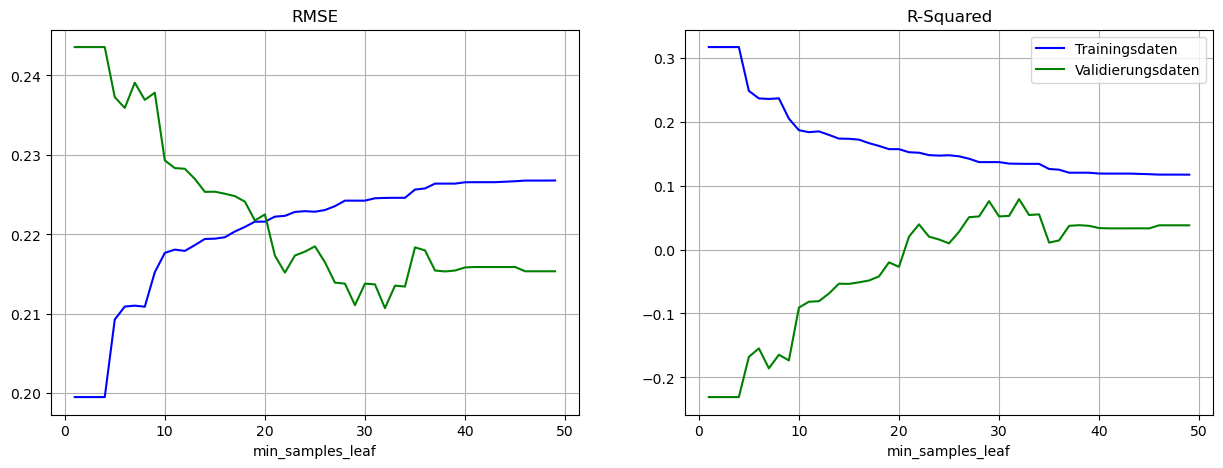

None :


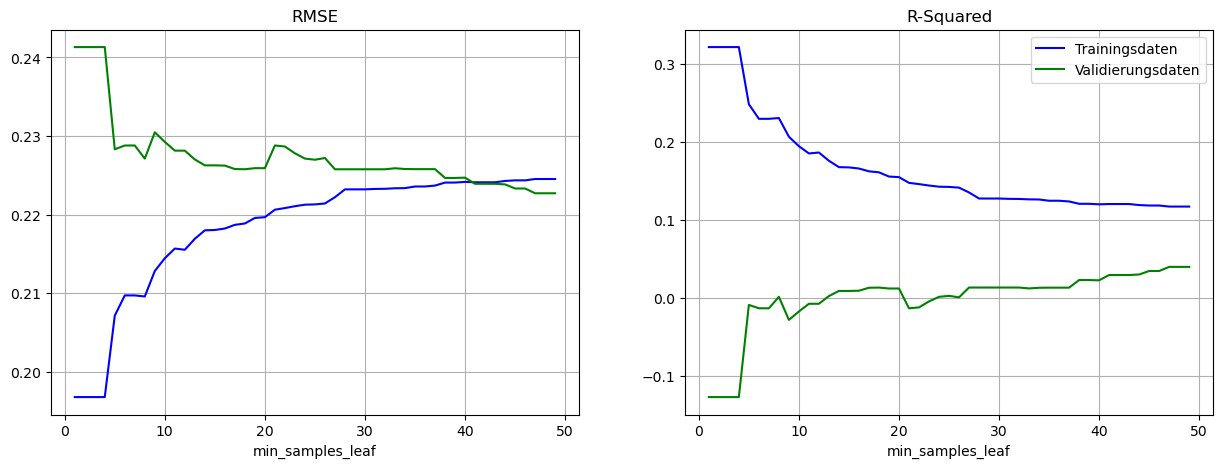

None :


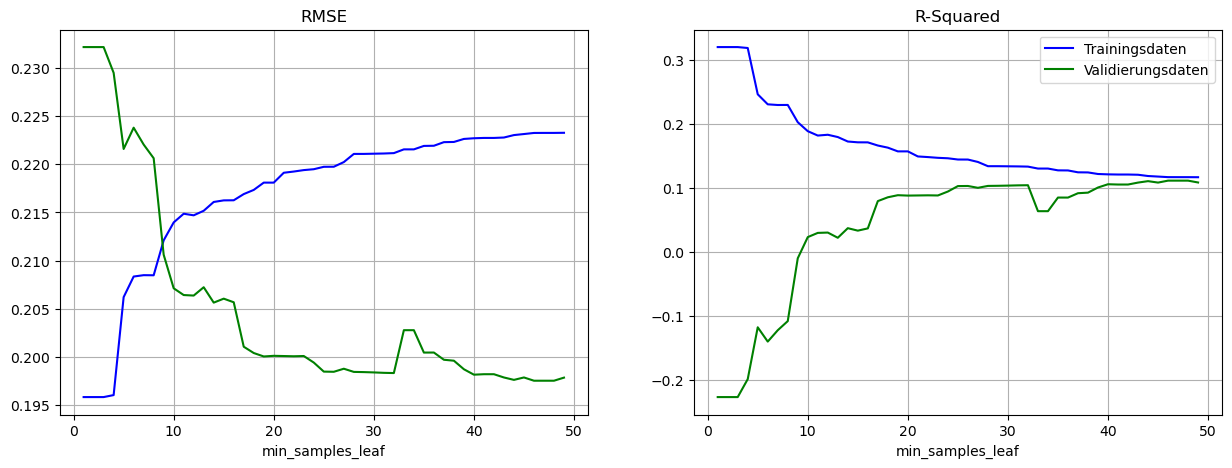

None :


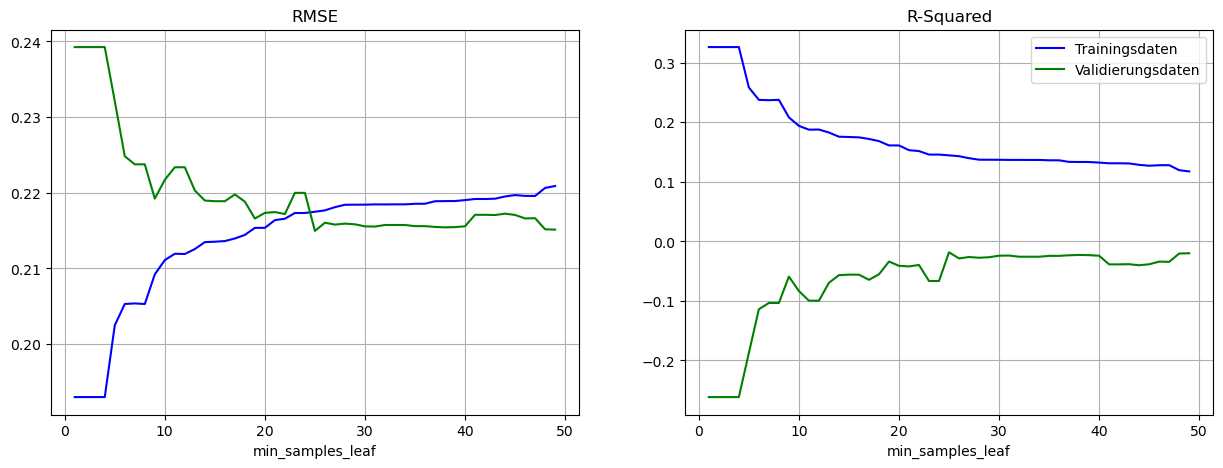

None :


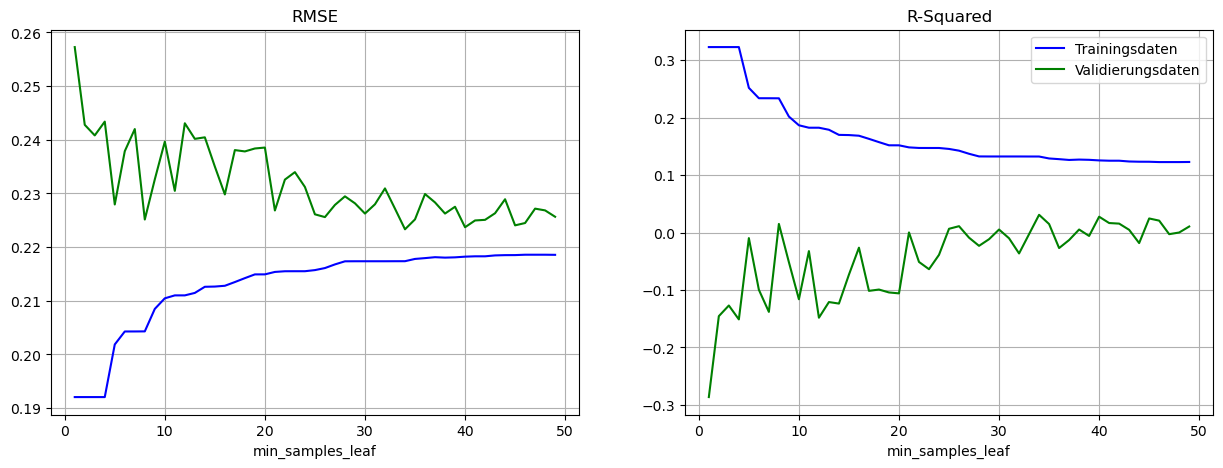

None :


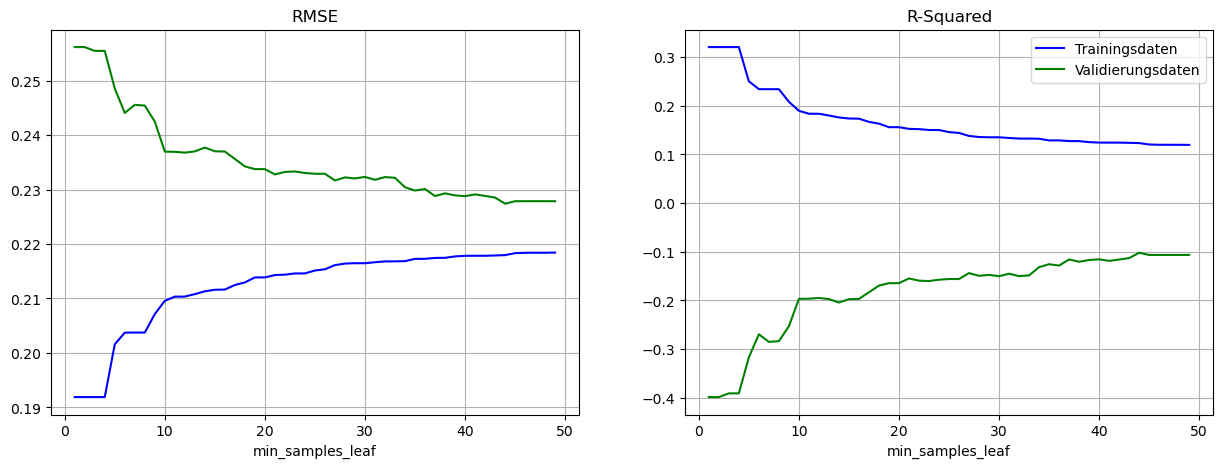

None :


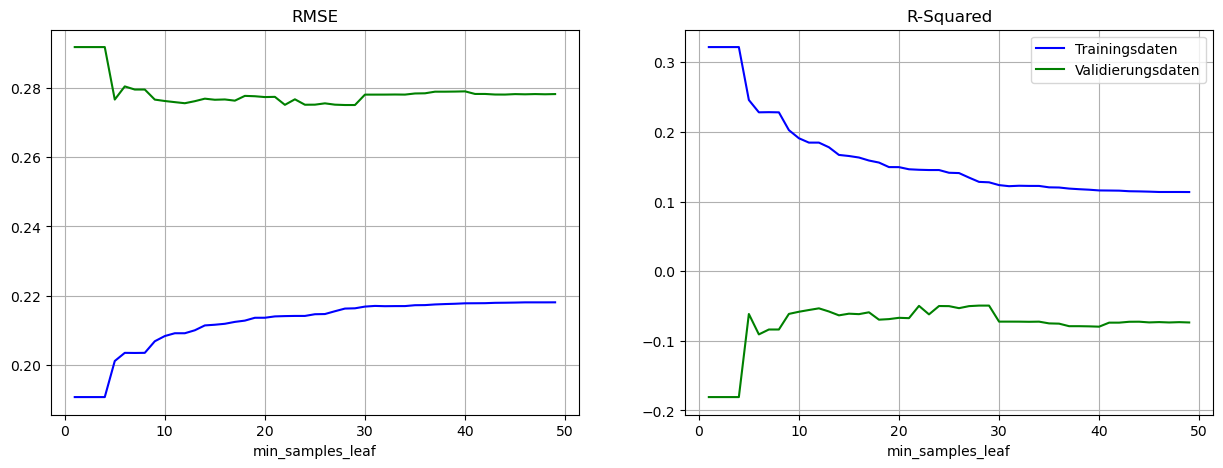

None :


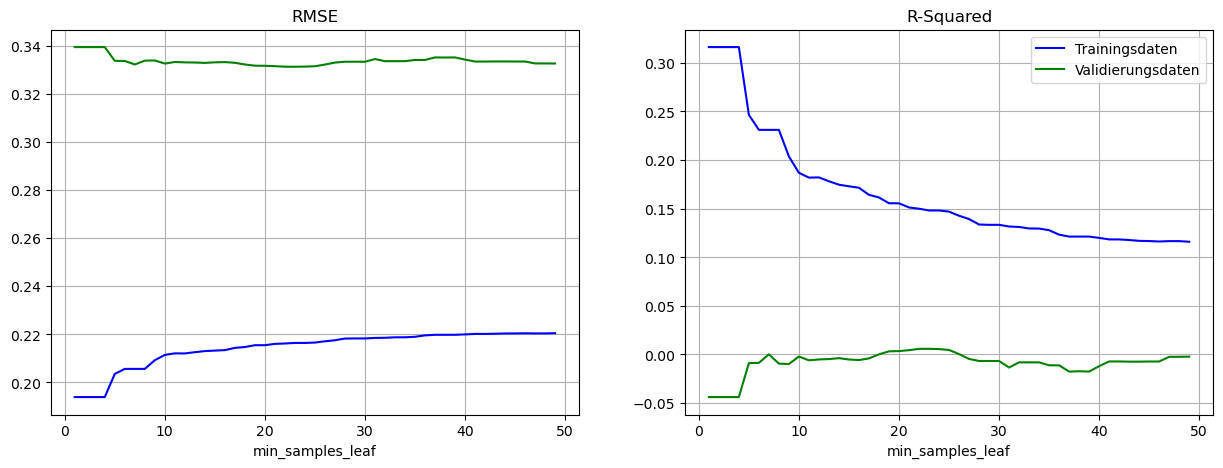

None :


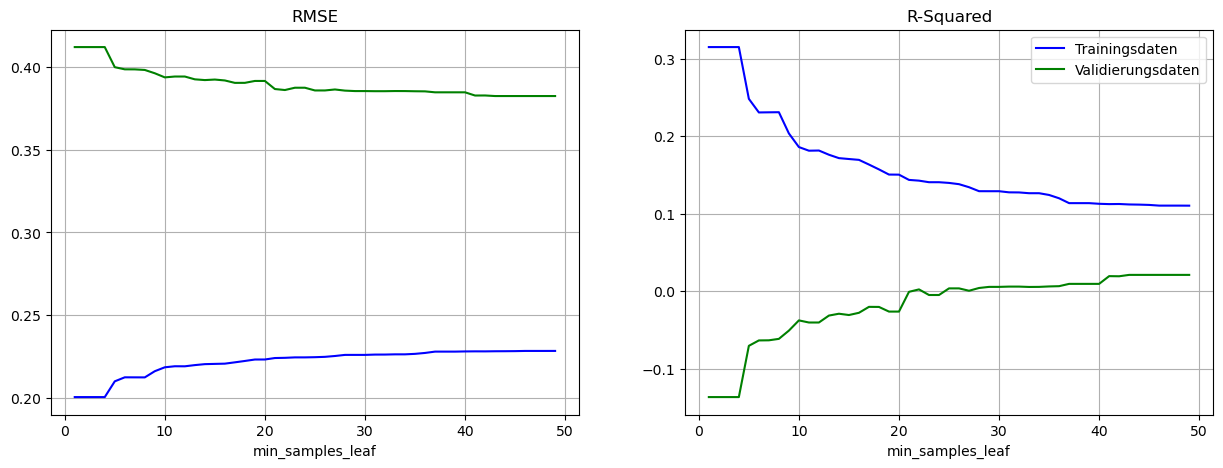

None :


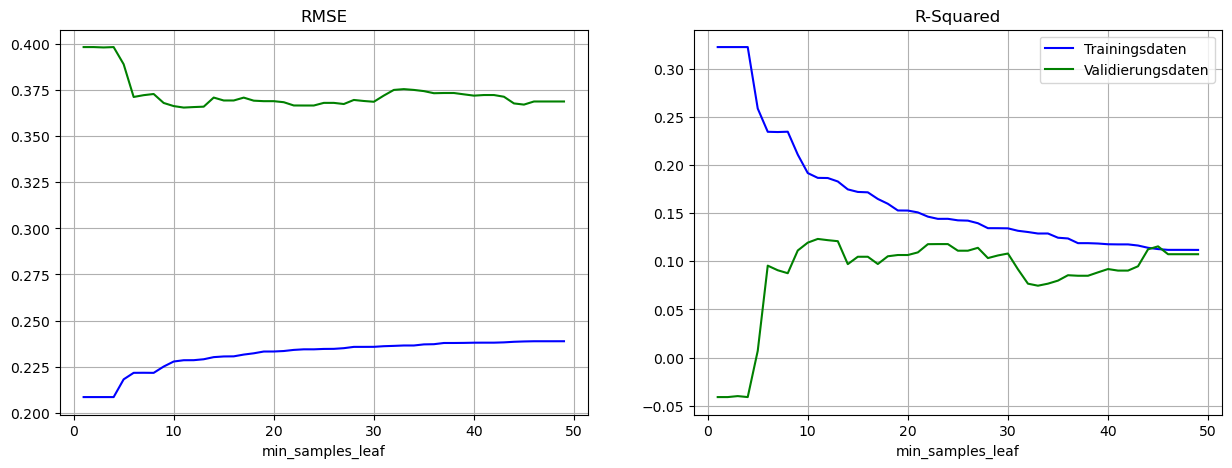

None :


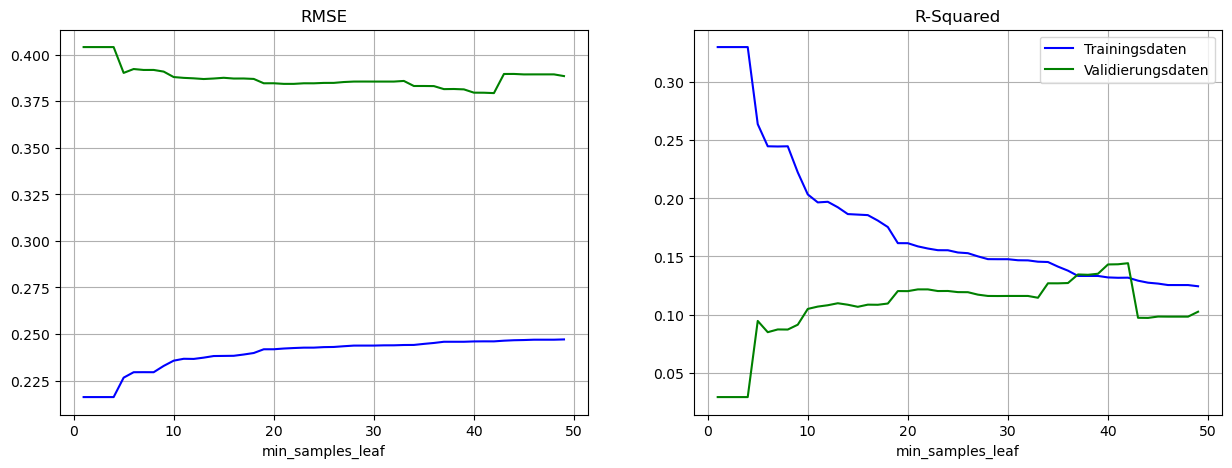

In [496]:
# Qualitätswerte für Datenset m11 mit min_samples_leaf=1-50 darstellen
rt_processing.get_rt_cv(m01_train, m01_val)
rt_processing.get_rt_cv(m02_train, m02_val)
rt_processing.get_rt_cv(m03_train, m03_val)
rt_processing.get_rt_cv(m04_train, m04_val)
rt_processing.get_rt_cv(m05_train, m05_val)
rt_processing.get_rt_cv(m06_train, m06_val)
rt_processing.get_rt_cv(m07_train, m07_val)
rt_processing.get_rt_cv(m08_train, m08_val)
rt_processing.get_rt_cv(m09_train, m09_val)
rt_processing.get_rt_cv(m10_train, m10_val)
rt_processing.get_rt_cv(m11_train, m11_val)

/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelo


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.13404237924027607 
 RMSE:  0.2245756043994092 
 MAE:  0.08511363862114928 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.07084795140315114 
 RMSE:  0.2116235521535596 
 MAE:  0.08126330664090523 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.11705161139141229 
 RMSE:  0.2245299149684188 
 MAE:  0.08502283966123352 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.039609533181948375 
 RMSE:  0.22271464999261026 
 MAE:  0.08812221307748826 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.1334971609009694 
 RMSE:  0.22114376960927182 
 MAE:  0.08267576174856714 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.10442204424460588 
 RMSE:  0.19832999946286292 
 MAE:  0.07451073615723885 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelo


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.11728659198842817 
 RMSE:  0.2208896730735486 
 MAE:  0.08328355980154105 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  -0.01976103292136 
 RMSE:  0.21509099239869947 
 MAE:  0.07943118499928184 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.13231452341302707 
 RMSE:  0.21736228135178182 
 MAE:  0.08108934355924298 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  -0.021862905492772144 
 RMSE:  0.22930997424192692 
 MAE:  0.09571100632467085 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.12333377248796995 
 RMSE:  0.2179651368729881 
 MAE:  0.08218341298941924 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  -0.10199525630269934 
 RMSE:  0.2274078535882497 
 MAE:  0.08899974463229748 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelo


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.1275582973365429 
 RMSE:  0.21638938910013258 
 MAE:  0.08106709431205304 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  -0.04925414034431341 
 RMSE:  0.2749723134707344 
 MAE:  0.12422938733019304 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.14696672696674162 
 RMSE:  0.2165634386555433 
 MAE:  0.08207619814499932 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.004647650260981906 
 RMSE:  0.3315137440211354 
 MAE:  0.13765895141211945 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.11112642751628121 
 RMSE:  0.22807288386606586 
 MAE:  0.09049338557243618 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.020872236038542158 
 RMSE:  0.3824840566330538 
 MAE:  0.19188307138500835 
 MAPE:  nan


/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelorarbeit/myBuxi/Dashboard/Code/Prognosemodell/Stündlich-pro_Haltepunkt/rt_processing.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((actual - pred) / actual)) * 100
/Users/manuel/Library/Mobile Documents/com~apple~CloudDocs/manuelguggisberg/Schule/HSLU/Bachelo


 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.11395022394532495 
 RMSE:  0.23857184109185542 
 MAE:  0.09685598489430508 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.11269928405961027 
 RMSE:  0.3675020424640849 
 MAE:  0.1802183393238333 
 MAPE:  nan

 RT_test :
Qualität auf Trainingsdaten: 
 R-squared:  0.13326126636740943 
 RMSE:  0.24580324198470951 
 MAE:  0.10104600233697579 
 MAPE:  nan
Qualität auf Validierungsdaten: 
 R-squared:  0.1344711693974191 
 RMSE:  0.3814654607516021 
 MAE:  0.20632802294113775 
 MAPE:  nan


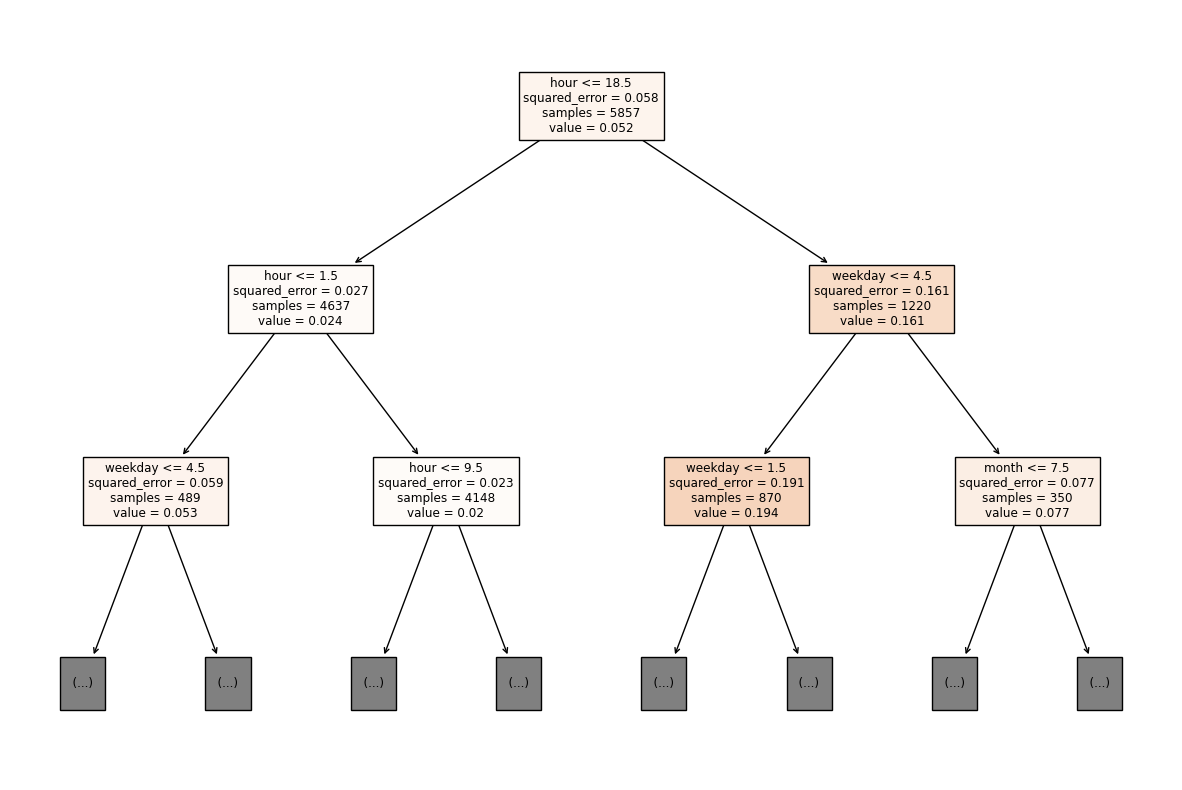

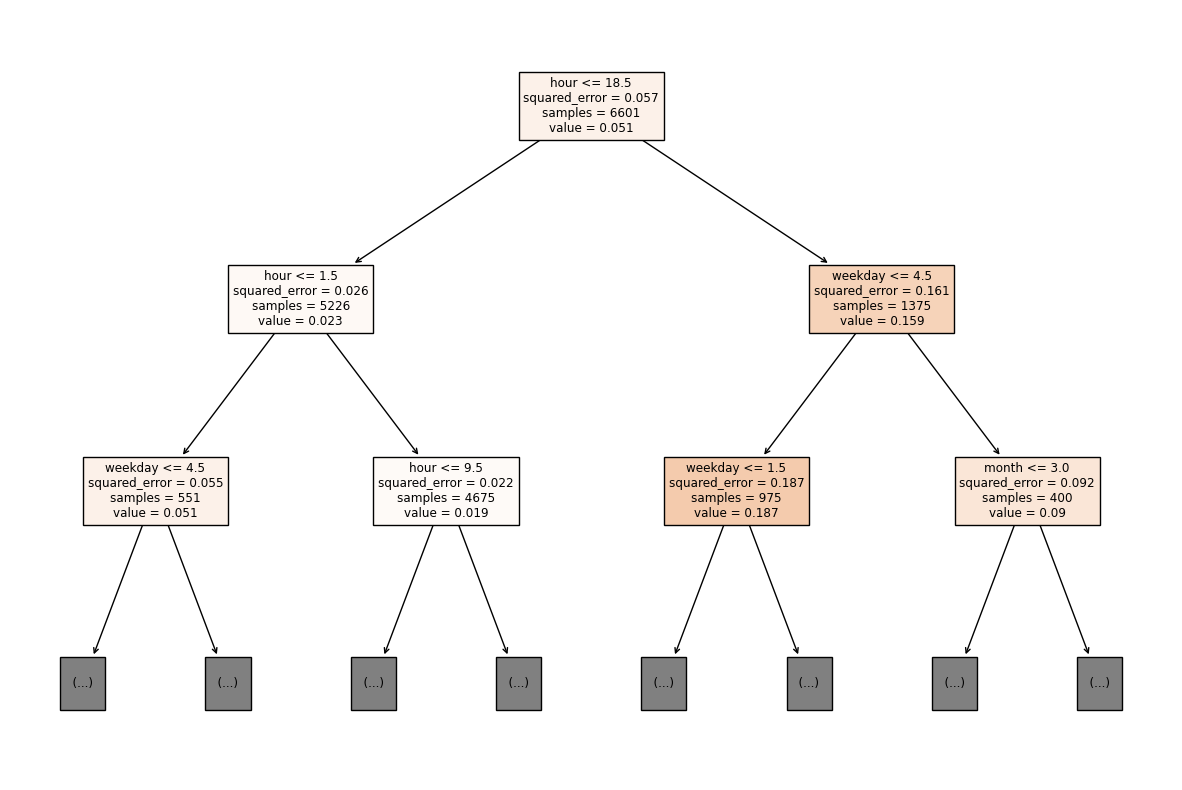

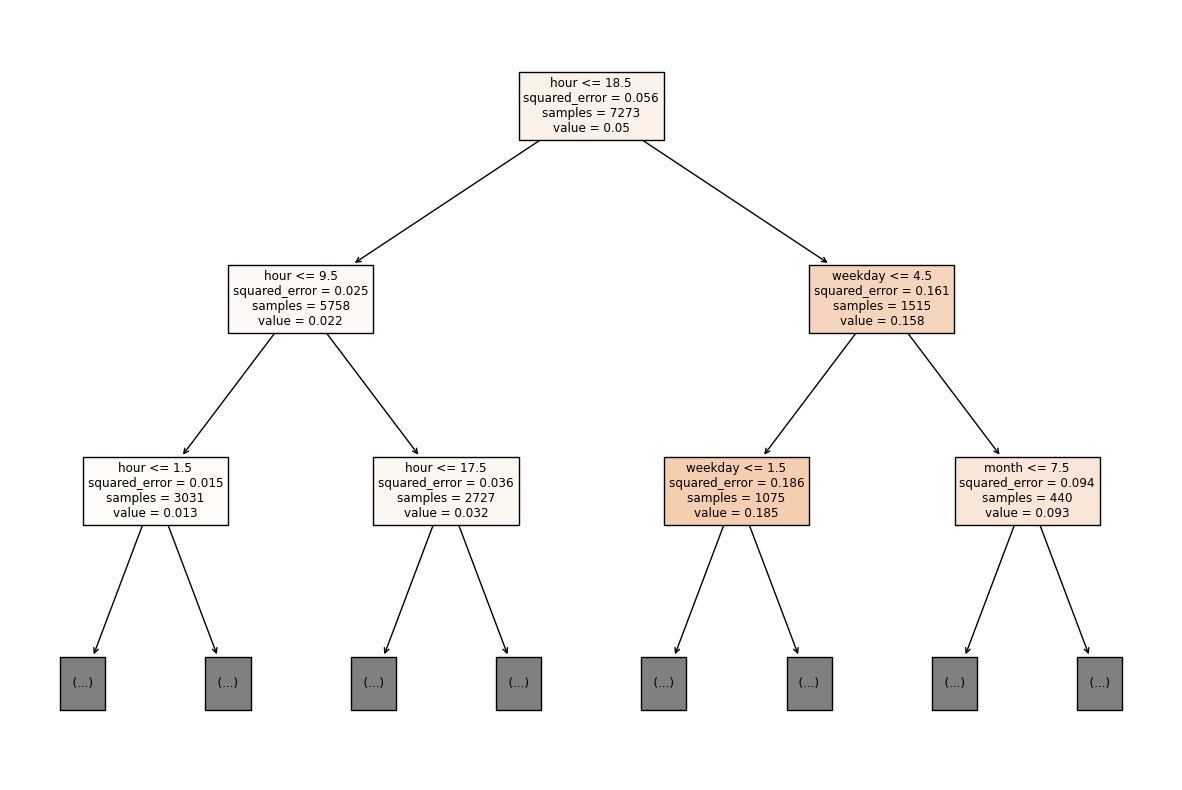

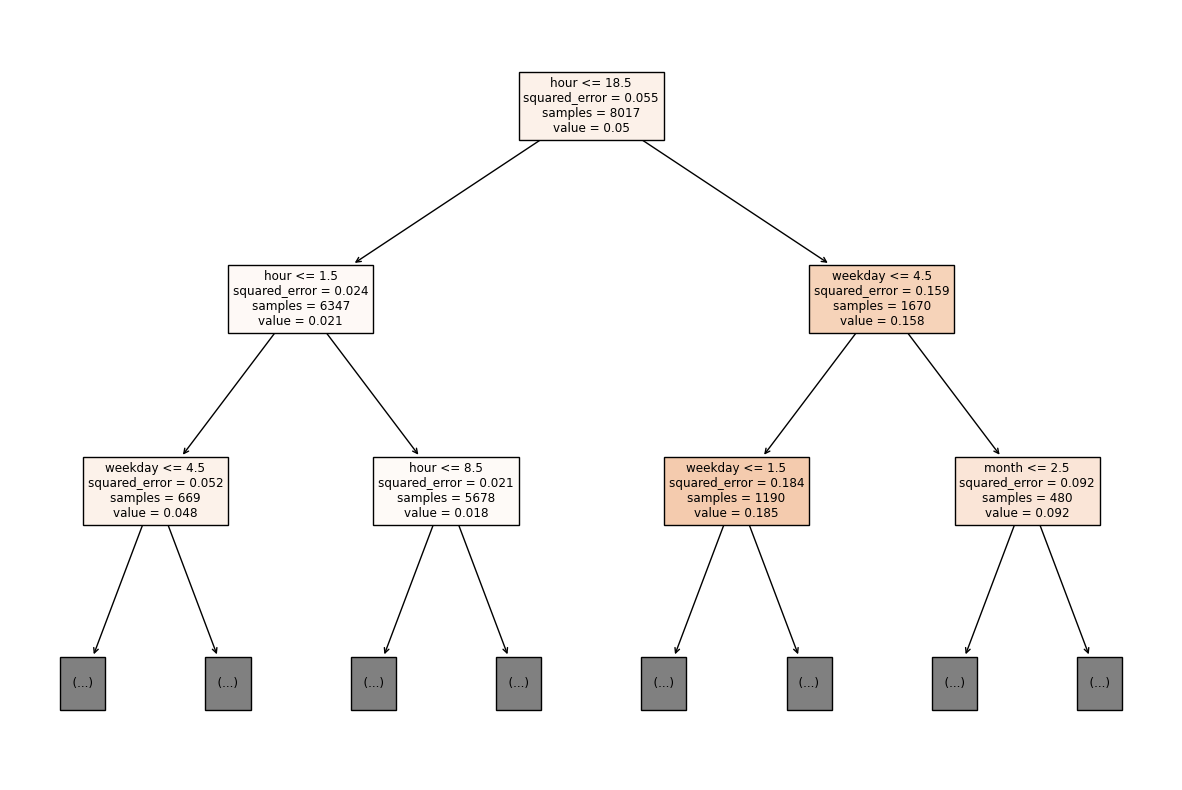

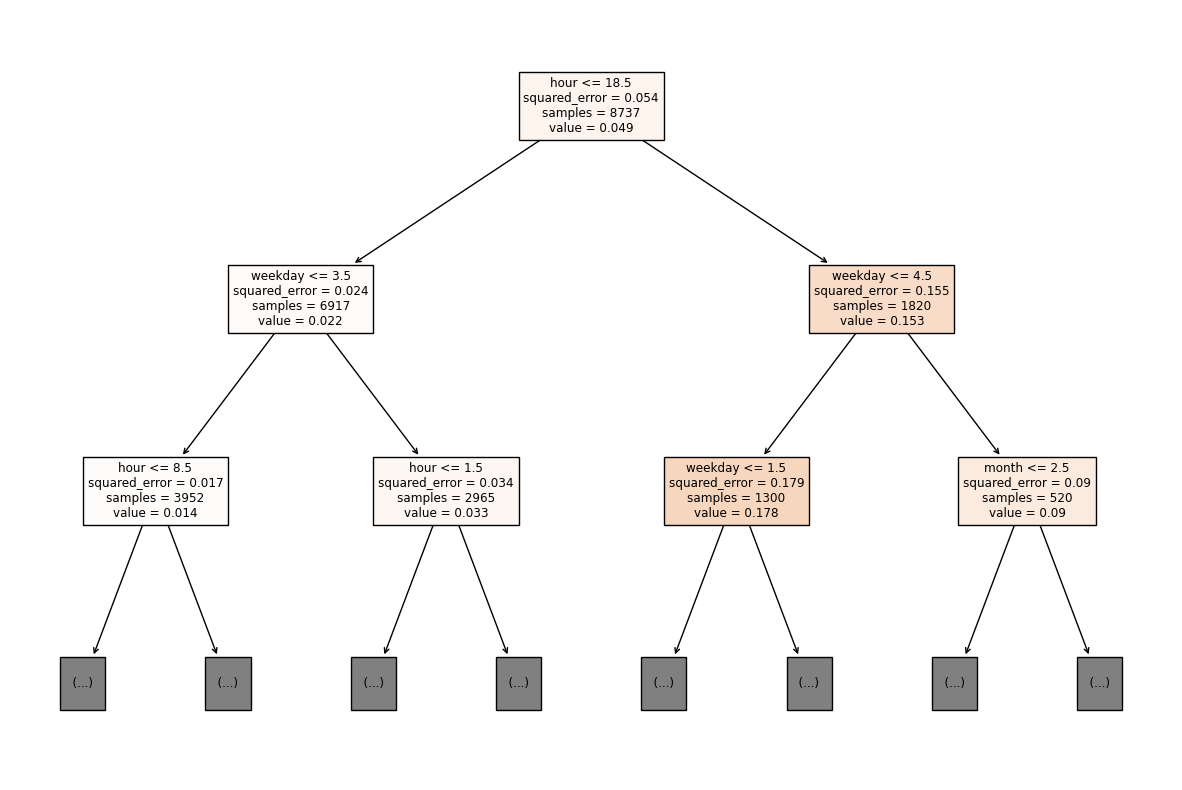

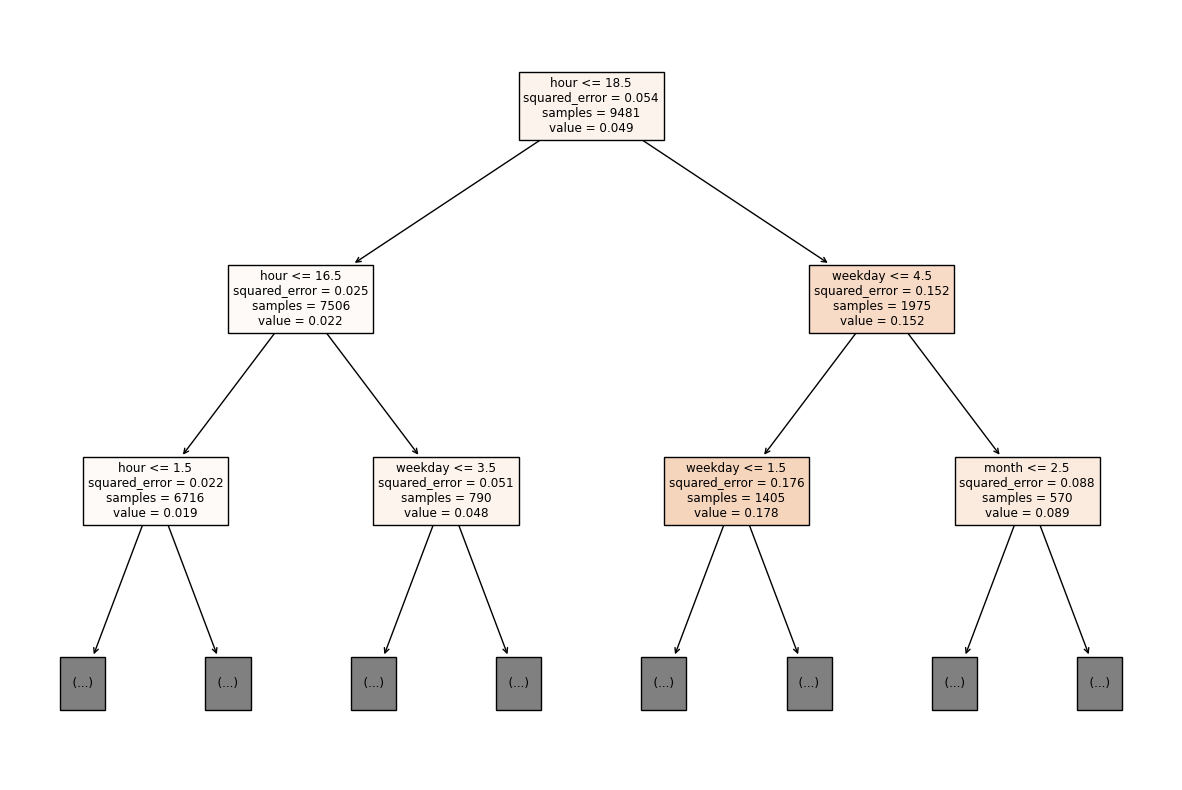

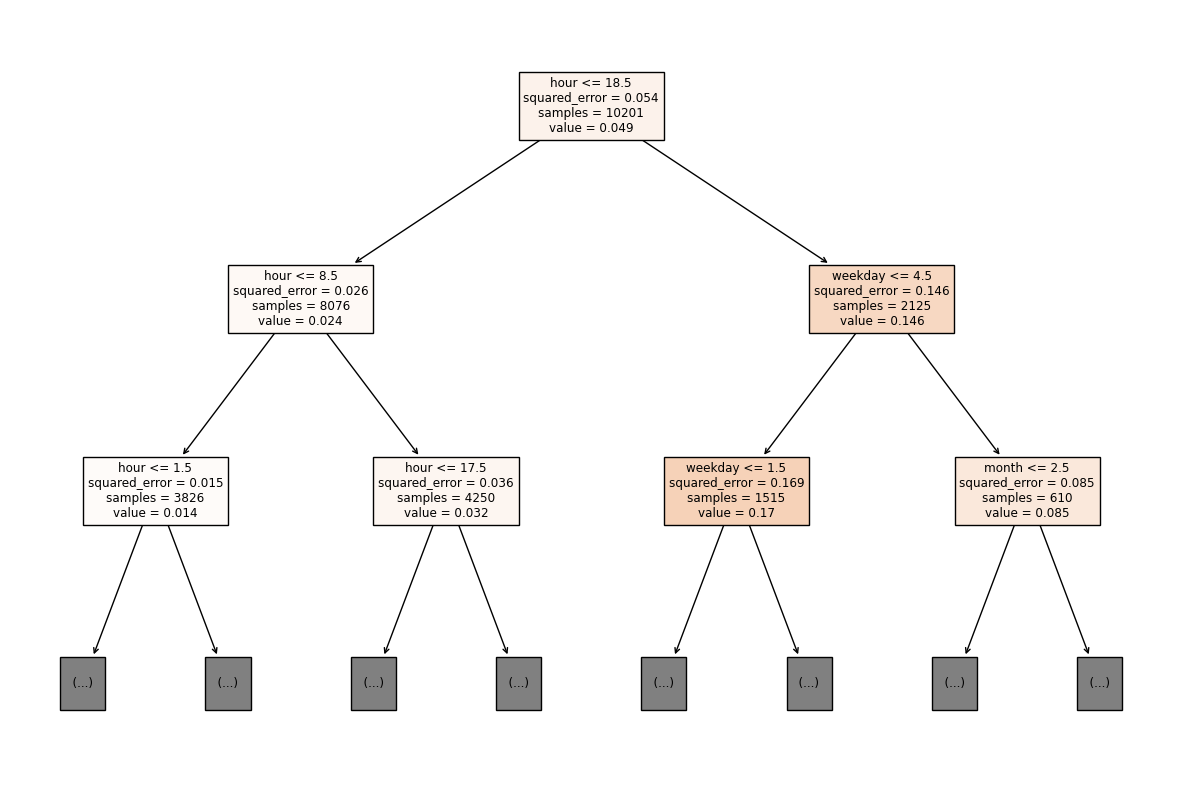

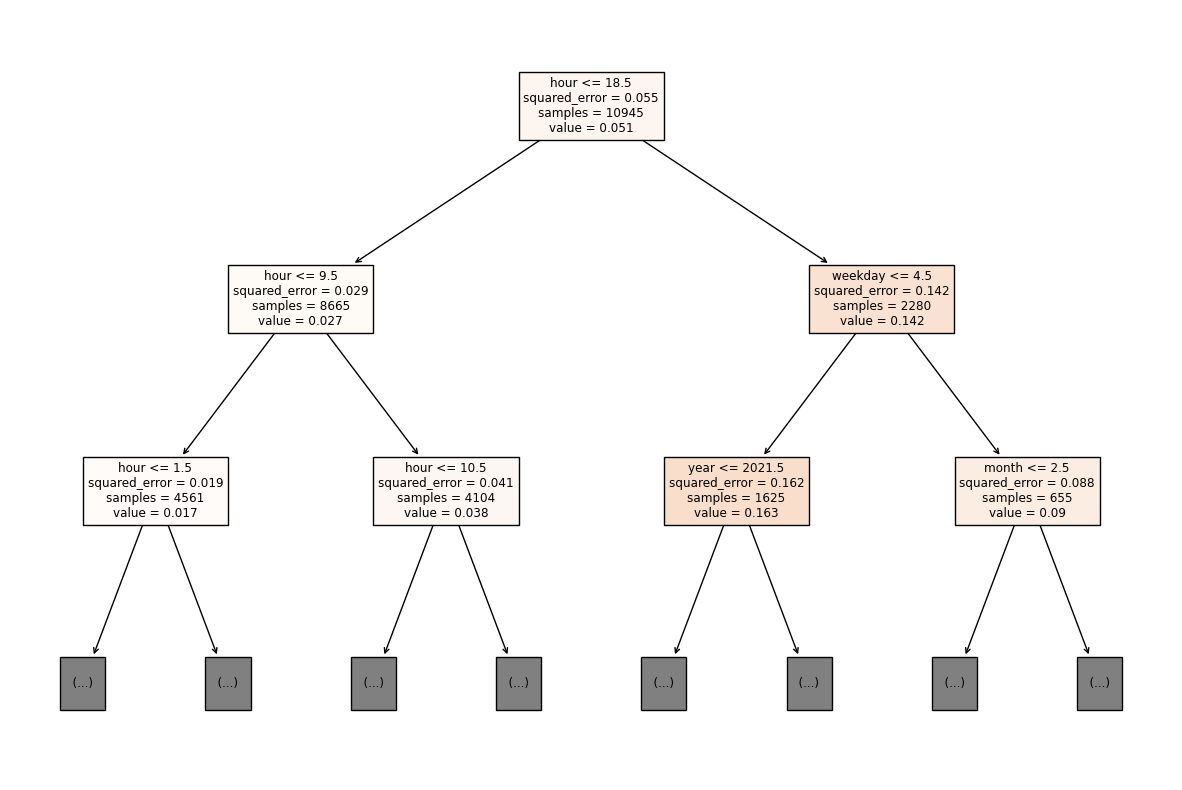

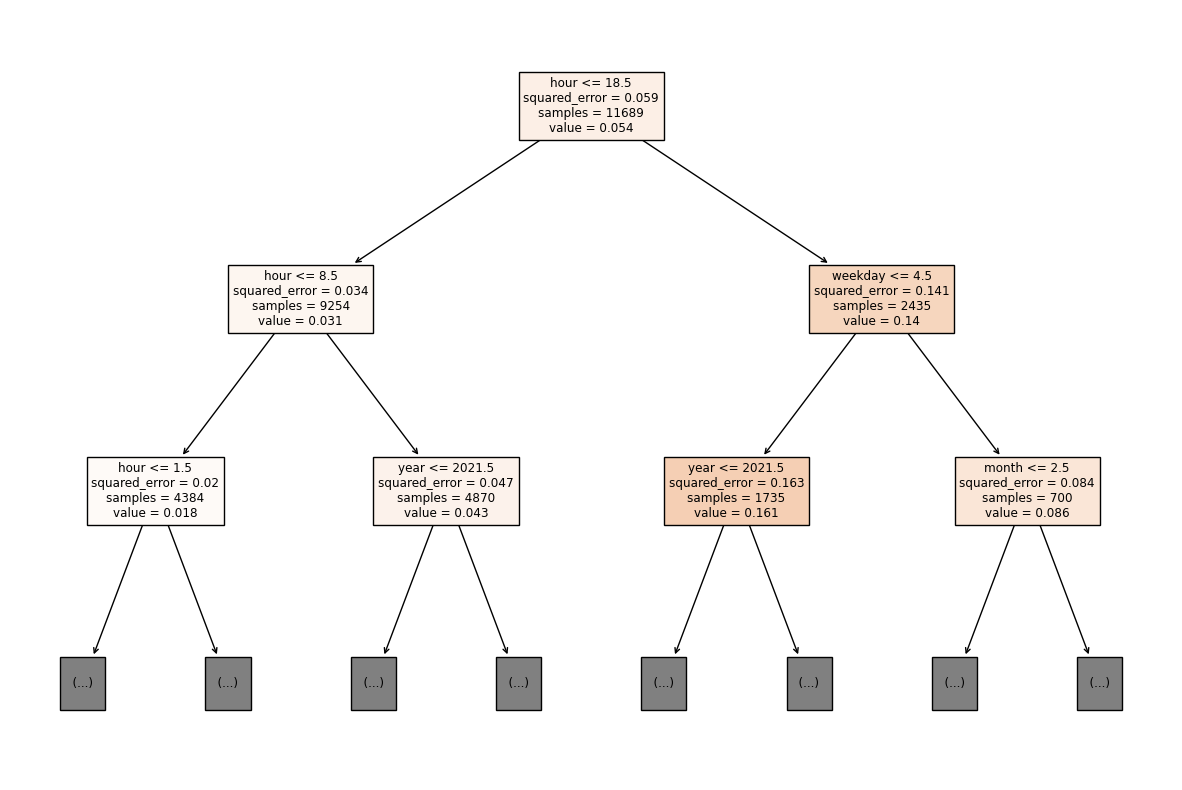

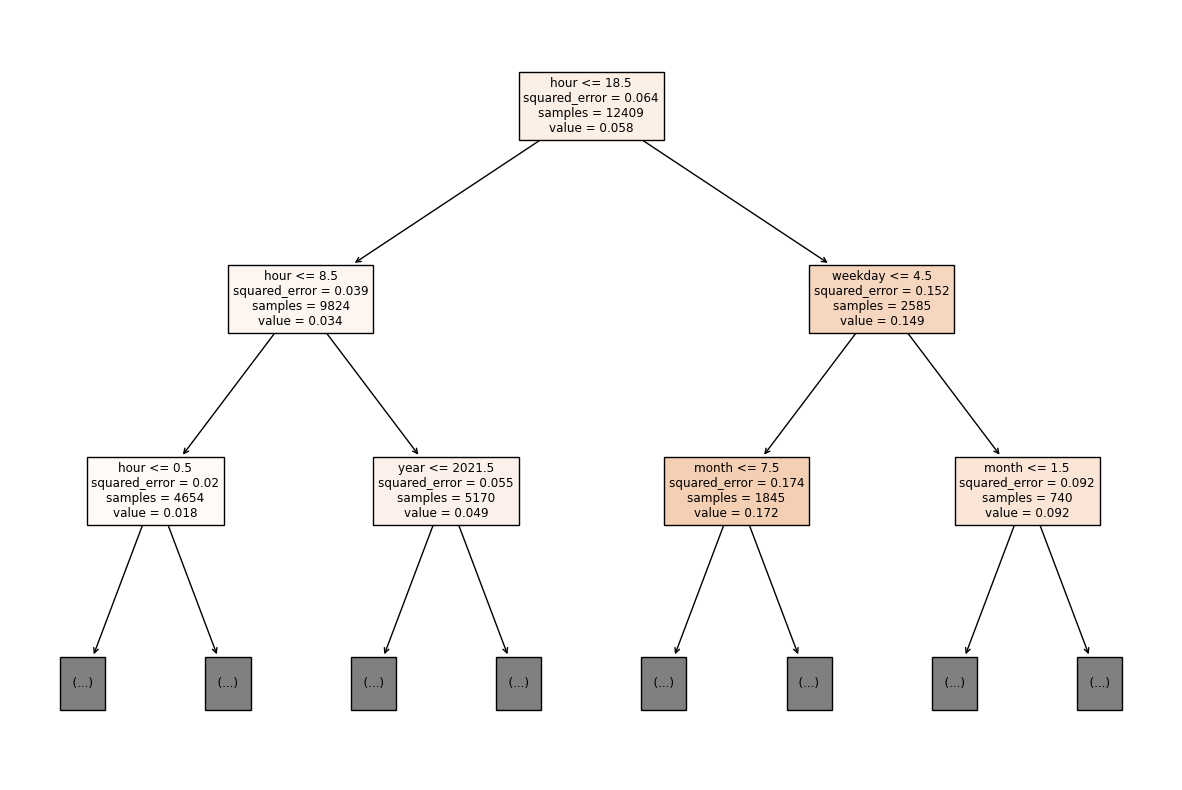

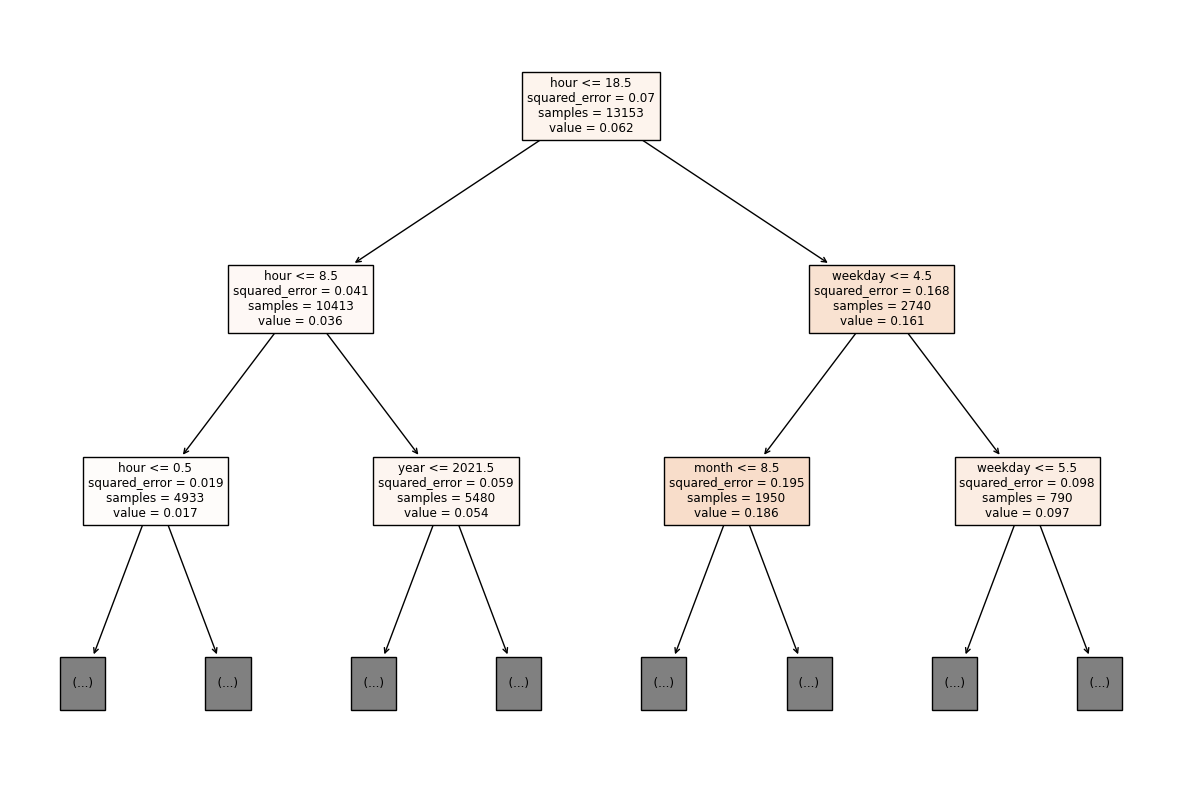

In [497]:
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m01_train, m01_val, m01_test, 32)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m02_train, m02_val, m02_test, 48)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m03_train, m03_val, m03_test, 32)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m04_train, m04_val, m04_test, 49)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m05_train, m05_val, m05_test, 34)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m06_train, m06_val, m06_test, 44)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m07_train, m07_val, m07_test, 29)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m08_train, m08_val, m08_test, 25)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m09_train, m09_val, m09_test, 45)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m10_train, m10_val, m10_test, 44)
qual_train.loc[len(qual_train)], qual_val.loc[len(qual_val)], qual_test.loc[len(qual_test)] = rt_processing.get_rt_performance(m11_train, m11_val, m11_test, 39)

Qualitätsmasse analysieren:

/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


<AxesSubplot:xlabel='MAE', ylabel='Model'>

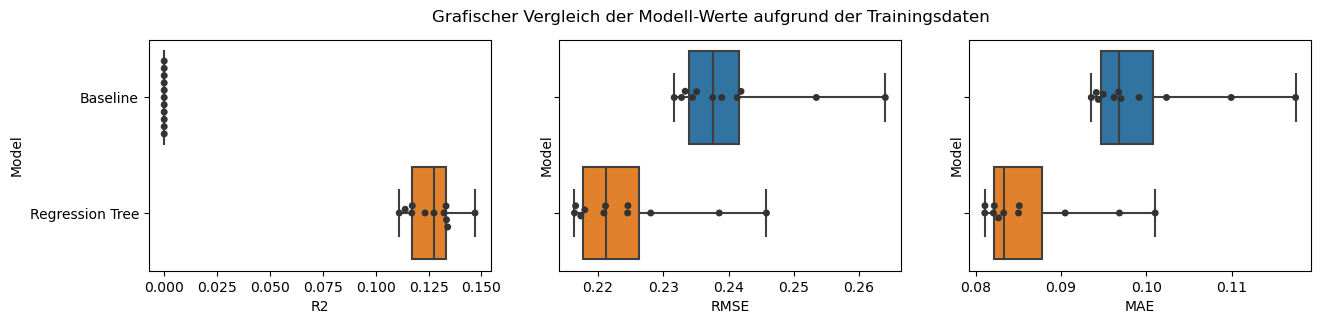

In [500]:
fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=True)
fig.suptitle('Grafischer Vergleich der Modell-Werte aufgrund der Trainingsdaten')

# R2
sns.boxplot(ax=axes[0], x="R2", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[0], x="R2", y="Model", data=qual_train, color=".2")

# RMSE
sns.boxplot(ax=axes[1], x="RMSE", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[1], x="RMSE", y="Model", data=qual_train, color=".2")

# MAE
sns.boxplot(ax=axes[2], x="MAE", y="Model", data=qual_train, whis=np.inf)
sns.swarmplot(ax=axes[2], x="MAE", y="Model", data=qual_train, color=".2")


/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1249: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/manuel/opt/anaconda3/envs/DSIntro_2020/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


<AxesSubplot:xlabel='MAE', ylabel='Model'>

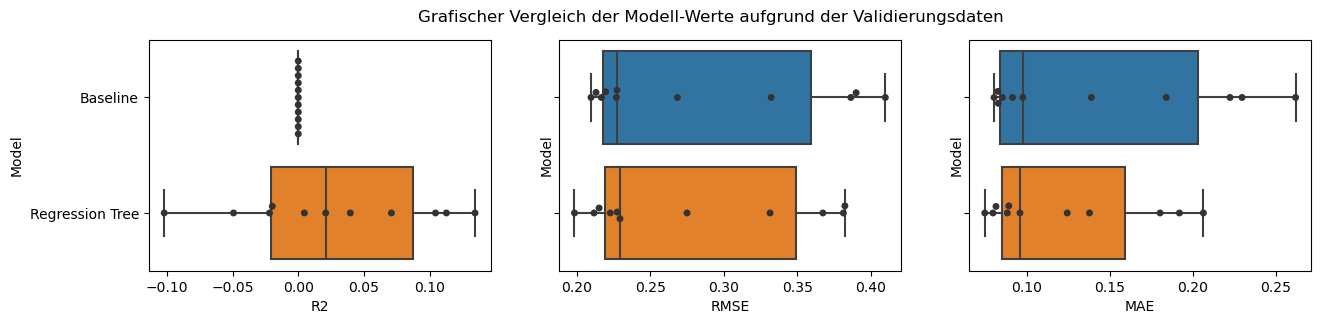

In [501]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
fig.suptitle('Grafischer Vergleich der Modell-Werte aufgrund der Validierungsdaten')

# R2
sns.boxplot(ax=axes[0], x="R2", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[0], x="R2", y="Model", data=qual_val, color=".2")

# RMSE
sns.boxplot(ax=axes[1], x="RMSE", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[1], x="RMSE", y="Model", data=qual_val, color=".2")

# MAE
sns.boxplot(ax=axes[2], x="MAE", y="Model", data=qual_val, whis=np.inf)
sns.swarmplot(ax=axes[2], x="MAE", y="Model", data=qual_val, color=".2")

In [502]:
# Durchschnitte Baseline
qual_val[qual_val.Model == 'Baseline'].mean()

R2      0.000000
RMSE    0.281844
MAE     0.141436
MAPE         inf
dtype: float64

In [541]:
# Durchschnitte Regression Tree
qual_val[qual_val.Model == 'Regression Tree'].mean()

R2      0.026791
RMSE    0.276583
MAE     0.122578
MAPE         NaN
dtype: float64

Prediciton analysieren:

In [508]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=39)
fitted_tree = reg_tree.fit(m11_train[['year', 'month', 'weekday', 'hour']].to_numpy(), m11_train[['cnt']].to_numpy())
val_y_pred  = fitted_tree.predict(m11_val[['year', 'month', 'weekday', 'hour']].to_numpy())

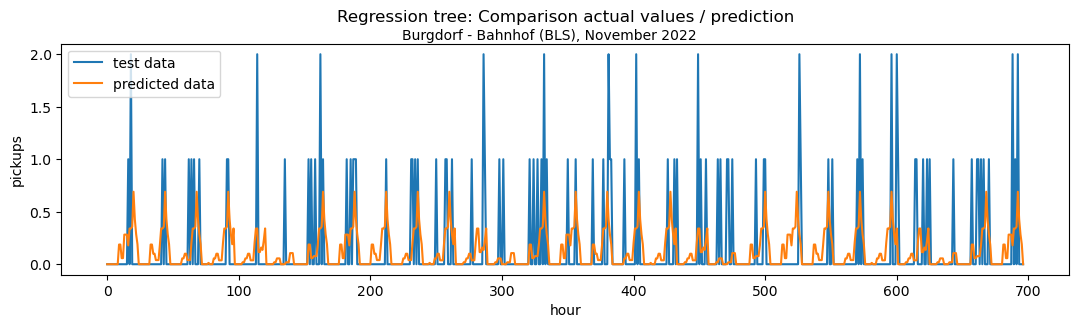

In [511]:
plt.figure(figsize=(13,3))
plt.title('Regression tree: Comparison actual values / prediction', y=1.06)
plt.suptitle('Burgdorf - Bahnhof (BLS), November 2022', fontsize=10, y=0.93)
plt.ylabel('pickups')
plt.xlabel('hour')
plt.plot(m11_val.cnt.to_numpy(), label="test data")
plt.plot(val_y_pred, label="predicted data")
plt.legend(loc = 'upper left')

In [531]:
# Prediciton-Peaks
m11_val['pred'] = val_y_pred
m11_val.nlargest(5, 'pred', keep='all')

,Datum,Station,cnt,station_nr,year,month,weekday,hour,mean_cnt,pred
20,2022-11-01 20:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2022,11,1,20,0.150646,0.690476
44,2022-11-02 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,2,20,0.150646,0.690476
68,2022-11-03 20:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2022,11,3,20,0.150646,0.690476
92,2022-11-04 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,4,20,0.150646,0.690476
164,2022-11-07 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,0,20,0.150646,0.690476
188,2022-11-08 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,1,20,0.150646,0.690476
212,2022-11-09 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,2,20,0.150646,0.690476
236,2022-11-10 20:00:00,Burgdorf - Bahnhof (BLS),1.0,111,2022,11,3,20,0.150646,0.690476
260,2022-11-11 20:00:00,Burgdorf - Bahnhof (BLS),0.0,111,2022,11,4,20,0.150646,0.690476
332,2022-11-14 20:00:00,Burgdorf - Bahnhof (BLS),2.0,111,2022,11,0,20,0.150646,0.690476


--> Die höchsten Predicitions sind immer um 20:00 Uhr

In [539]:
m11_val[m11_val.hour.isin([19, 20, 21])].groupby(['hour', 'weekday'])['pred'].describe()

count      mean  std       min       25%       50%       75%  \
hour weekday                                                                 
19   0          4.0  0.357143  0.0  0.357143  0.357143  0.357143  0.357143   
     1          5.0  0.357143  0.0  0.357143  0.357143  0.357143  0.357143   
     2          4.0  0.357143  0.0  0.357143  0.357143  0.357143  0.357143   
     3          4.0  0.357143  0.0  0.357143  0.357143  0.357143  0.357143   
     4          4.0  0.357143  0.0  0.357143  0.357143  0.357143  0.357143   
     5          4.0  0.115385  0.0  0.115385  0.115385  0.115385  0.115385   
     6          4.0  0.106061  0.0  0.106061  0.106061  0.106061  0.106061   
20   0          4.0  0.690476  0.0  0.690476  0.690476  0.690476  0.690476   
     1          5.0  0.690476  0.0  0.690476  0.690476  0.690476  0.690476   
     2          4.0  0.690476  0.0  0.690476  0.690476  0.690476  0.690476   
     3          4.0  0.690476  0.0  0.690476  0.690476  0.690476  0.690476   
     4          4.0  0.690476  0.0  0.690476  0.690476  0.690476  0.690476   
     5          4.0  0.115385  0.0  0.115385  0.115385  0.115385  0.115385   
     6          4.0  0.106061  0.0  0.106061  0.106061  0.106061  0.106061   
21   0          4.0  0.428571  0.0  0.428571  0.428571  0.428571  0.428571   
     1          5.0  0.428571  0.0  0.428571  0.428571  0.428571  0.428571   
     2          4.0  0.428571  0.0  0.428571  0.428571  0.428571  0.428571   
     3          4.0  0.428571  0.0  0.428571  0.428571  0.428571  0.428571   
     4          4.0  0.428571  0.0  0.428571  0.428571  0.428571  0.428571   
     5          4.0  0.159091  0.0  0.159091  0.159091  0.159091  0.159091   
     6          4.0  0.106061  0.0  0.106061  0.106061  0.106061  0.106061   

                   max  
hour weekday            
19   0        0.357143  
     1        0.357143  
     2        0.357143  
     3        0.357143  
     4        0.357143  
     5        0.115385  
     6        0.106061  
20   0        0.690476  
     1        0.690476  
     2        0.690476  
     3        0.690476  
     4        0.690476  
     5        0.115385  
     6        0.106061  
21   0        0.428571  
     1        0.428571  
     2        0.428571  
     3        0.428571  
     4        0.428571  
     5        0.159091  
     6        0.106061

--> Am Wochenende sind die Werte zu diesen "Peak"-Zeiten jedoch deutlich tiefer